# GEOG 5543 Final Project
## Current Weather Finder
### Arlan Hegenbarth and Alec Olson

In [ ]:
# set up packages
%pip install rasterio
%pip install contextily
from sklearn.neighbors import KNeighborsRegressor
import requests
import time
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from multiprocessing import Pool
import numpy as np
import itertools
import rasterio
from matplotlib import pyplot as plt
import contextily as cx
from shapely.geometry import Point

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 13.7 MB/s eta 0:00:00


### 1.
Get a list of NOAA zones in the U.S.\
Iterate through the zones and grab the Observation Stations (from which we can grab current weather data).\
Remove duplicates from the list of Observation Stations.

In [ ]:
zones = requests.get('https://api.weather.gov/zones?type=land')
zones = zones.json()

stations = []
for i in range(len(zones['features'])):
    if zones['features'][i]['properties']['state'] not in ['AK', 'AS', 'FM', 'GU', 'HI', 'MH', 'MP', 'PR', 'PW', 'VI']:         # exclude Alaska, American Samoa, Micronesia, Guam, Hawaii, the Marshall Islands, Northern Mariana Islands, Puerto Rico, Palau, and the Virgin Islands to simplify the interpolation
        zoneID = zones['features'][i]['properties']['id']
        observationStations = zones['features'][i]['properties']['observationStations']
        if observationStations != []:
            station = observationStations[0][33:]
            stations.append(station)

stations = list(set(stations))    # remove duplicates

### 2.
Function to request weather data from a NOAA Observation Station. If it returns a valid response (200), grab the current temperature, relative humidity, windspeed, and sky condition (cloudy, rainy, or snowy).\
1 indicates that it is cloudy (or rainy or snowy).\
Also store the coordinates of the Observation Station.\
Store all these values in a list [`station`, `temp`, `relativeHumidity`, `windSpeed`, `cloudy`, `rainy`, `snowy`, `lat`, `lon`, `geometry`], and then return this list.

In [ ]:
stationWeatherList = []             # the list that will store weather data for each Observation Station
stationsToCompare = stations[:]     # if we want, we can compare only a subset of the total stations

print(f'\nThere are {len(stationsToCompare)} stations in the U.S. to compare.\n')

def getLatestObservation(station):
    weather = requests.get(f'https://api.weather.gov/stations/{station}/observations/latest')
    if weather.status_code == 200:
        weather = weather.json()

        temp = weather['properties']['temperature']['value']
        if temp != None:
          temp = int(temp) * 1.8 + 32    # convert Celsius to Fahrenheit

        relativeHumidity = weather['properties']['relativeHumidity']['value']

        windSpeed = weather['properties']['windSpeed']['value']
        if windSpeed != None:
          windSpeed = int(windSpeed) * 1.609    # convert km/h to mph

        skyCondition = weather['properties']['textDescription']
        cloudy, rainy, snowy = None, None, None
        if skyCondition != "":        # skyCondition is a string. If the string is empty, keep cloudy, rainy, and snowy as None. If the string is not empty, that means that we can extract the sky conditions from it.
          cloudy, rainy, snowy = 0, 0, 0
          if 'Cloudy' in skyCondition:
            cloudy = 1
          elif 'Rain' in skyCondition or 'Drizzle' in skyCondition:
            rainy = 1
            cloudy = 1
          elif 'Snow' in skyCondition:
            snowy = 1
            cloudy = 1


        coordinates = weather['geometry']['coordinates']
        geometry= Point(coordinates[0], coordinates[1])

        lat = coordinates[1]
        lon = coordinates[0]

        weatherList = [station, temp, relativeHumidity, windSpeed, cloudy, rainy, snowy, lat, lon, geometry]

        return weatherList


There are 1500 stations in the U.S. to compare.



### 3.
Request weather data from NOAA.\
Use 8 pools to make 8 API calls at a time. \
Format weather data into a geodataframe

In [ ]:
%%time
start_time = time.time()

my_pool = Pool(8)
stationWeatherList = my_pool.map(getLatestObservation, stationsToCompare)
stationWeatherList = [x for x in stationWeatherList if x is not None]   # remove stations that have no data
my_pool.close()

end_time = time.time()

CPU times: user 206 ms, sys: 131 ms, total: 337 ms
Wall time: 31.9 s


In [ ]:
weather_stations = gpd.GeoDataFrame(data=stationWeatherList, columns=['station', 'temp', 'humidity', 'windspeed', 'cloudy', 'rainy', 'snowy', 'lat', 'lon', 'geometry'], geometry='geometry')
weather_stations.head()

,station,temp,humidity,windspeed,cloudy,rainy,snowy,lat,lon,geometry
0,KNTU,62.6,83.677643,22.526,1.0,1.0,0.0,36.82,-76.03,POINT (-76.03 36.82)
1,KGUC,17.6,64.020215,NaN,0.0,0.0,0.0,38.53,-106.93,POINT (-106.93 38.53)
2,KMOP,35.6,89.800383,8.045,1.0,0.0,0.0,43.62,-84.74,POINT (-84.74 43.62)
3,KAAS,46.4,93.403401,0.000,1.0,0.0,0.0,37.35,-85.32,POINT (-85.32 37.35)
4,KMVE,26.6,92.806460,17.699,1.0,0.0,0.0,44.97,-95.72,POINT (-95.72 44.97)


<Axes: >

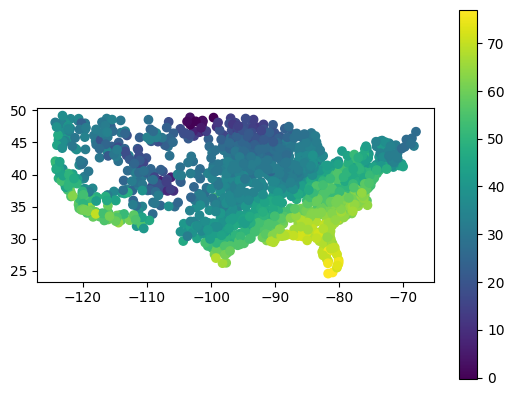

In [ ]:
weather_stations.plot(column='temp', legend=True)

### 4.
Set Grid Boundaries as numpy arrays. \
Create a US Mask following the grid cells so that only cells within the continental US are used. \
Islands were removed from the polygon to reduce computation time.

In [ ]:
# set bounds
gridx = np.arange(-125.0, -66.5, 0.1)
gridy = np.arange(49.5, 24.5, -0.1)
combinations = list(itertools.product(gridy, gridx))
grid = pd.DataFrame(combinations, columns=['lat', 'lon'])

<ipython-input-8-e32582429a61>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  US_geo = gpd.GeoSeries(US.iloc[np.argmax(US.area)]['geometry'])


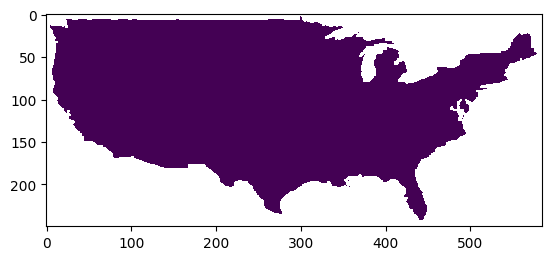

In [ ]:
# US mask - this cell takes about a minute to run, attempts to speed it up further were unsuccessful
US = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_nation_20m.zip')
US.to_crs(epsg=4326, inplace=True)

# Keep only largest polygon (remove islands) - this makes the computation much faster
US = US.explode()
US_geo = gpd.GeoSeries(US.iloc[np.argmax(US.area)]['geometry'])

# Convert to raster
grid_geo = gpd.GeoSeries.from_xy(grid['lon'],grid['lat'],crs="EPSG:4326")
us_mask = grid_geo.within(US_geo[0])
us_mask = np.round(np.reshape(us_mask,newshape=(len(gridy),len(gridx))))
us_mask[us_mask == 0] = float('inf')
plt.imshow(us_mask)

### 5.
Build IDW interpolations for all 6 variables

In [ ]:
vars = ['temp','humidity','windspeed','cloudy','rainy','snowy']
fields = []
for var in vars:
  var_subset = weather_stations.dropna(subset=[var]) # remove missing values
  loc = var_subset[['lat','lon']]
  val = var_subset[var]

  # IDW Interpolation
  model = KNeighborsRegressor(algorithm='kd_tree',n_neighbors=12,weights='distance').fit(loc,val)
  pred = np.reshape(model.predict(grid[['lat','lon']]),newshape=(len(gridy),len(gridx)))
  fields.append(pred)

### 6.
Find the region of the US with the most simlar weather conditions to the user input. \
This is the only part of the code that need to be rerun when changing the desired weather variables. \
To refresh the weather data, parts 3 and 5 will need to be rerun.

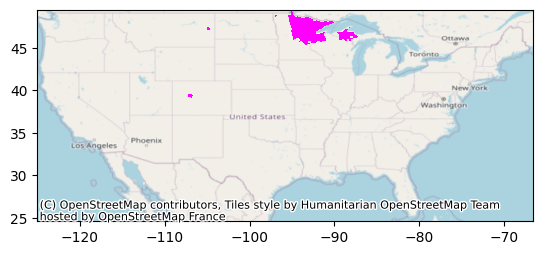

In [ ]:
########################## EDIT HERE ##########################

# Input Variables
desired_temp = 15     # In Fahrenheit
desired_humidity = 68 # Percent 0-100
desired_wind = 10     # In mph
cloudy = 1            # 0 means clear skies; 1 means cloudy
rainy = 0             # 0 means no rain; 1 means rain
snowy = 1             # 0 means no snow; 1 means snow

# Advanced Settings
per_result = 0.02     # percent of the country to select; 1.0 is 100%
weights = [2, 0.5, 1, 0.5, 0.5, 0.5] # weights represent the importance of the input variables, in the same order

######################### STOP EDITING #######################

weights = np.array(weights)
norm_diffs = [0,0,0,0,0,0]
user_input = [desired_temp, desired_humidity, desired_wind, cloudy, rainy, snowy]

# get normalized differences on a 0 to 1 scale
for i in range(len(weights)):
  diff = abs(fields[i] - user_input[i])
  norm_diffs[i] = np.array(diff) / max(np.array(diff).flatten())
norm_diffs = np.array(norm_diffs)

# calculate similarity scores
sim_score = np.sum(weights.reshape(-1, 1, 1) * norm_diffs, axis = 0) * us_mask

# find and display the percentage of the US with the most simlarity
q = np.quantile(sim_score.flatten()[np.where(sim_score.flatten() != float('Inf'))], per_result)
masked_data = np.ma.masked_where(sim_score > q, sim_score)
fig, ax = plt.subplots()
ax.imshow(masked_data/masked_data, cmap='spring', extent=(min(gridx),max(gridx),min(gridy),max(gridy)))
cx.add_basemap(ax, crs=4326, zorder=-1)